# Deep Inside - AUTOENCODERES

In [1]:
## If the only purpose of autoencoders was to copy the input to the output, they would be useless. Indeed, we hope 
## that, by training the autoencoder to copy the input to the output, the latent representation h will take on 
## useful properties.
## This can be achieved by creating constraints on the copying task. One way to obtain useful features from the 
## autoencoder is to constrain h to have smaller dimensions than x, in this case the autoencoder is called 
## undercomplete. By training an undercomplete representation, we force the autoencoder to learn the most salient 
## features of the training data. If the autoencoder is given too much capacity, it can learn to perform the 
## copying task without extracting any useful information about the distribution of the data. This can also occur 
## if the dimension of the latent representation is the same as the input, and in the overcomplete case, where the 
## dimension of the latent representation is greater than the input. In these cases, even a linear encoder and 
## linear decoder can learn to copy the input to the output without learning anything useful about the data 
## distribution. Ideally, one could train any architecture of autoencoder successfully, choosing the code dimension
## and the capacity of the encoder and decoder based on the complexity of distribution to be modeled.

In [2]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, add
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

Using TensorFlow backend.


In [47]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

In [48]:
## Normalizing the data

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [49]:
## Flattening the images for the Fully-Connected Networks

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


# Vanilla Encoder

In [6]:
## The first network is the most simple autoencoder. It has three layers : Input - encoded - decoded

In [7]:
input_size = 784
hidden_size = 64
output_size = 784

In [8]:
## we see that we have an undercomplete autoencoder as the hidden layer dimension (64) is smaller than the 
## input (784). This constraint will impose our neural net to learn a compressed representation of data.

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

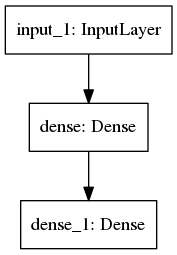

In [9]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder, to_file='vanilla_autoencoder.png')

In [10]:
## Training

epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, 
                          verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 32us/sample - loss: 0.0443 - val_loss: 0.0218
Epoch 2/5
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0168 - val_loss: 0.0123
Epoch 3/5
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0103 - val_loss: 0.0083
Epoch 4/5
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0075 - val_loss: 0.0064
Epoch 5/5
60000/60000 [==============================] - 1s 21us/sample - loss: 0.0061 - val_loss: 0.0055


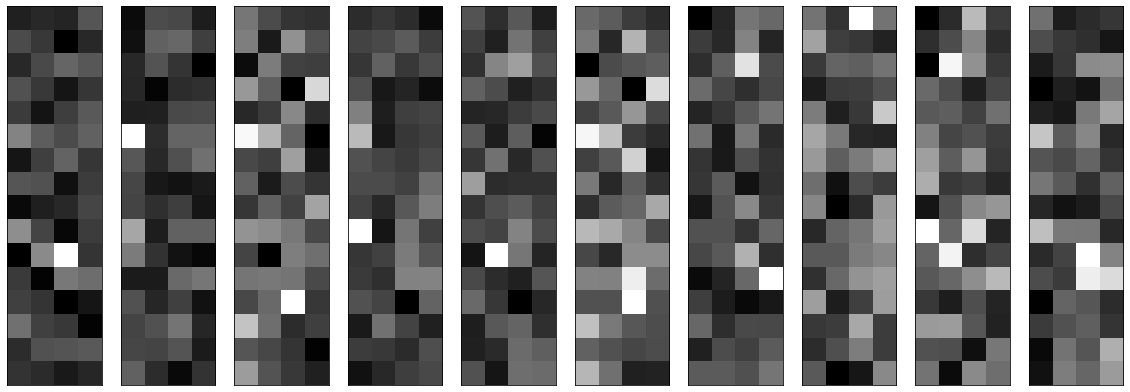

In [11]:
## Enbeddings made by the encoder of size 64

conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 16).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

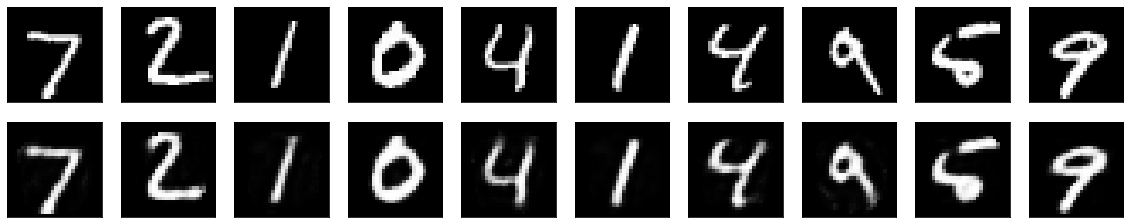

In [12]:
## Predicting on the test images

decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction/decoded imgs
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


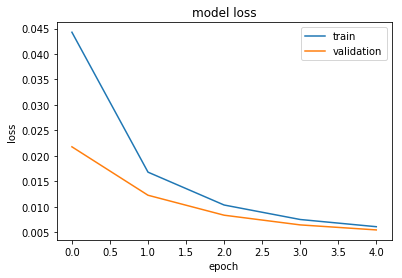

In [13]:
## Plotting the loss

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Multilayer autoencoder 

In [14]:
## We extend the idea of the first network to more layers

input_size = 784
hidden_size = 128
code_size = 64

x = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(x)
h = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(h)
r = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

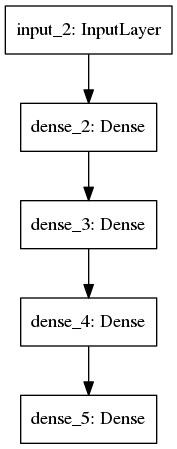

In [15]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder, to_file='Multilayer_autoencoder.png')

In [16]:
## Training

epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, 
                          epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 37us/sample - loss: 0.0407 - val_loss: 0.0190
Epoch 2/5
60000/60000 [==============================] - 2s 30us/sample - loss: 0.0160 - val_loss: 0.0133
Epoch 3/5
60000/60000 [==============================] - 2s 33us/sample - loss: 0.0121 - val_loss: 0.0107
Epoch 4/5
60000/60000 [==============================] - 2s 36us/sample - loss: 0.0104 - val_loss: 0.0095
Epoch 5/5
60000/60000 [==============================] - 2s 35us/sample - loss: 0.0094 - val_loss: 0.0086


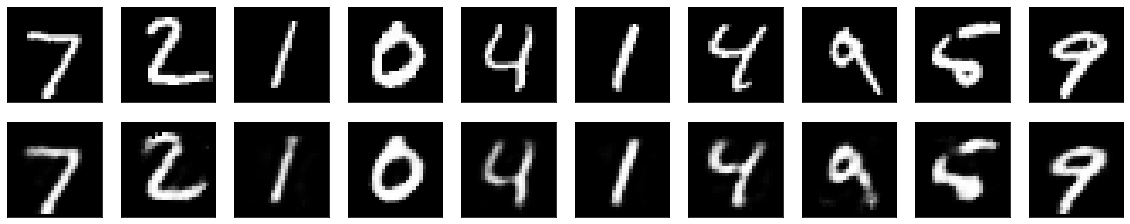

In [17]:
## Predicting the results

decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


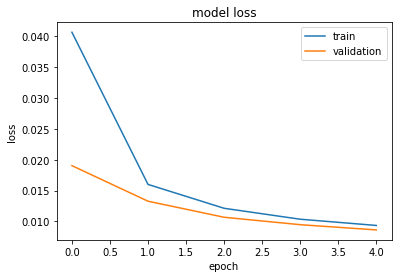

In [18]:
## Plotting the losses

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Convolutional autoencoder

In [34]:
## can autoencoders be used with Convolutions instead of Fully-connected layers ?
## The answer is yes and the principle is the same, but using images (3D vectors) instead of flattened 1D vectors.
## The input image is downsampled to give a latent representation of smaller dimensions and force the autoencoder
## to learn a compressed version of the images.

In [71]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [80]:
x = Input(shape=(28, 28,1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv1_2)
conv1_3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
h = MaxPooling2D((2, 2), padding='same')(conv1_3)


# Decoder
conv2_1 = Conv2D(8, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
conv2_3 = Conv2D(16, (3, 3), activation='relu')(up2)
up3 = UpSampling2D((2, 2))(conv2_3)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 4, 8)           0  

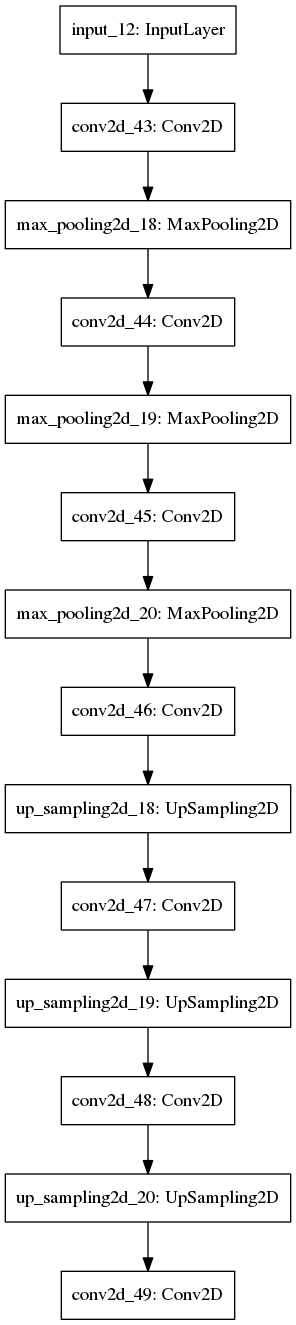

In [73]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder, to_file='Convolutional_autoencoder.png')

In [74]:
## Training

epochs = 5
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, 
                          epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.2152 - val_loss: 0.1487
Epoch 2/5
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1369 - val_loss: 0.1276
Epoch 3/5
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.1237 - val_loss: 0.1189
Epoch 4/5
60000/60000 [==============================] - 73s 1ms/sample - loss: 0.1170 - val_loss: 0.1136
Epoch 5/5
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.1127 - val_loss: 0.1101


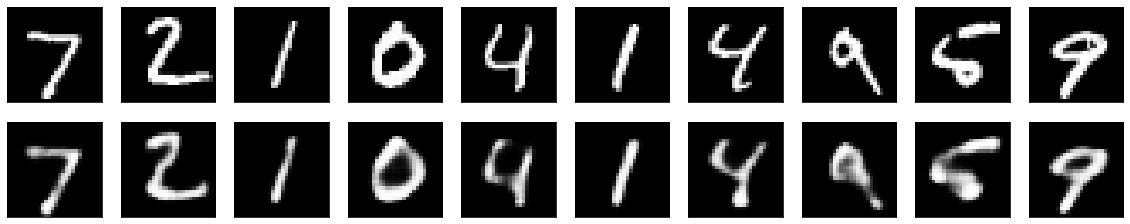

In [75]:
## Predicting the results

decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


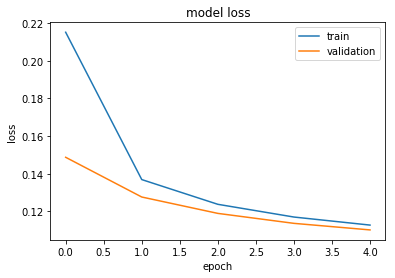

In [76]:
## Plotting the losses

print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Regularized autoencoder

Two types of regularization are described :

    Sparse autoencoder
    Denoising autoencoder



In [41]:
## There are other ways we can constraint the reconstruction of an autoencoder than to impose a hidden layer of 
## smaller dimension than the input. Rather than limiting the model capacity by keeping the encoder and decoder 
## shallow and the code size small, regularized autoencoders use a loss function that encourages the model to 
## have other properties besides the ability to copy its input to its output. In practice, we usually find two 
## types of regularized autoencoder: the sparse autoencoder and the denoising autoencoder.

## 1. Sparse autoencoder

In [42]:
## Sparse autoencoders are typically used to learn features for another task such as classification. 
## An autoencoder that has been regularized to be sparse must respond to unique statistical features of the 
## dataset it has been trained on, rather than simply acting as an identity function. In this way, training to 
## perform the copying task with a sparsity penalty can yield a model that has learned features as a byproduct.
## Another way we can constraint the reconstruction of autoencoder is to impose a constraint in its loss. We could,
## for example, add a reguralization term in the loss function. Doing this will make our autoencoder learn sparse 
## representation of data.
## Notice in our hidden layer, we added an l1 activity regularizer, that will apply a penalty to the loss function
## during the optimization phase. As result, the representation is now sparser compared to the vanilla autoencoder.

In [50]:
input_size = 784
hidden_size = 32
output_size = 784

In [51]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')

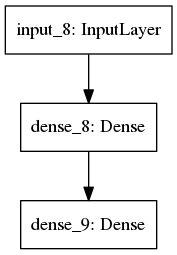

In [52]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder, to_file='Sparse_autoencoder.png')

In [53]:
epochs = 15
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, 
                          verbose=1, validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 2s 26us/sample - loss: 0.0599 - val_loss: 0.0365
Epoch 2/15
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0315 - val_loss: 0.0270
Epoch 3/15
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0248 - val_loss: 0.0224
Epoch 4/15
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0213 - val_loss: 0.0198
Epoch 5/15
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0194 - val_loss: 0.0184
Epoch 6/15
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0183 - val_loss: 0.0175
Epoch 7/15
60000/60000 [==============================] - 1s 23us/sample - loss: 0.0176 - val_loss: 0.0169
Epoch 8/15
60000/60000 [==============================] - 1s 22us/sample - loss: 0.0170 - val_loss: 0.0164
Epoch 9/15
60000/60000 [==============================] - 1s 19us/sample - loss: 0.0166 - val_

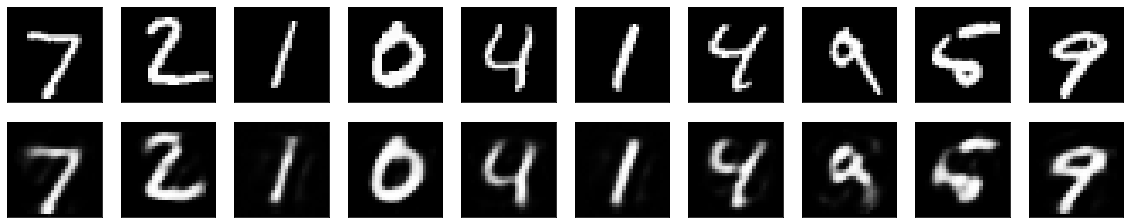

In [54]:
decoded_imgs = autoencoder.predict(X_test)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


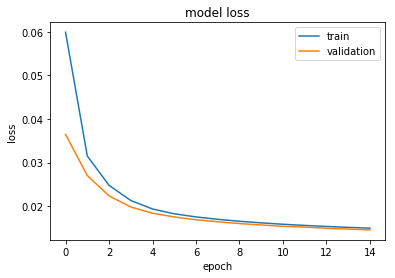

In [55]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## 2. Denoising autoencoder

In [70]:
## Rather than adding a penalty to the loss function, we can obtain an autoencoder that learns something useful by
## changing the reconstruction error term of the loss function. This can be done by adding some noise of the input
## image and make the autoencoder learn to remove it. By this means, the encoder will extract the most important 
## features and learn a robuster representation of the data.

In [77]:
nb_classes = 10

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [78]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [81]:
x = Input(shape=(28, 28, 1))

# Encoder
conv1_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)

autoencoder = Model(inputs=x,outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_26 (UpSampling (None, 14, 14, 32)        0  

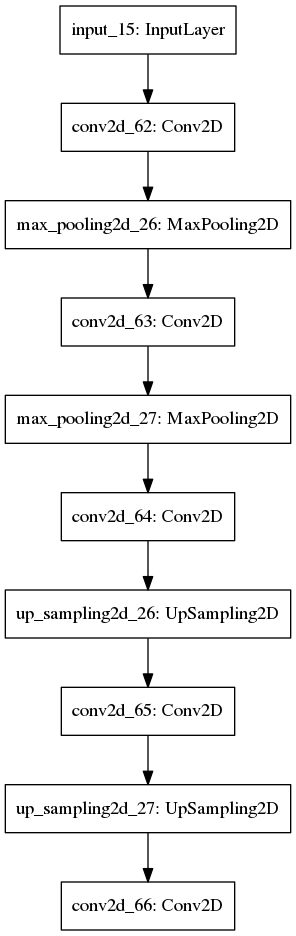

In [82]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder, to_file='Denoising_autoencoder.png')

In [83]:
epochs = 3
batch_size = 128

history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, 
                          verbose=1, validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 147s 2ms/sample - loss: 0.1672 - val_loss: 0.1180
Epoch 2/3
60000/60000 [==============================] - 143s 2ms/sample - loss: 0.1145 - val_loss: 0.1094
Epoch 3/3
60000/60000 [==============================] - 125s 2ms/sample - loss: 0.1084 - val_loss: 0.1053


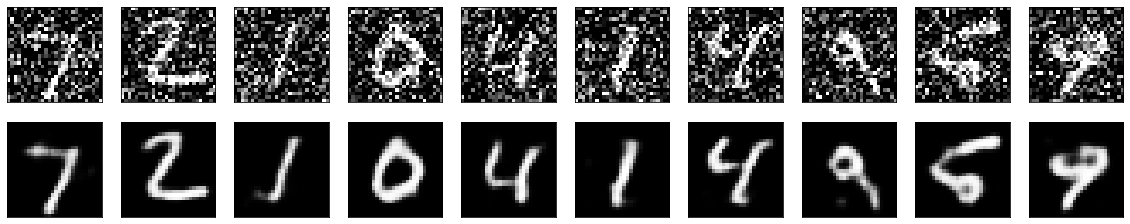

In [84]:
decoded_imgs = autoencoder.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['val_loss', 'loss'])


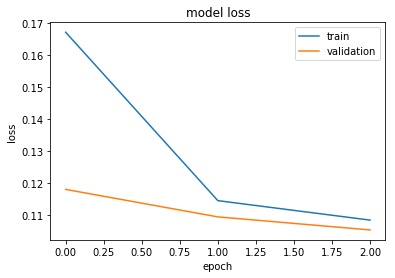

In [85]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()